<a href="https://colab.research.google.com/github/michaelhasey/galv_prep/blob/master/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import Libraries
%matplotlib inline

import os
import matplotlib.pyplot as plt

# from models.WGANGP import WGANGP
# from utils.loaders import load_celeb
import pickle
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# # ('./gdrive/My Drive/datasets/dataset_neoclassical_large_test/)
def load_celeb(data_name, image_size, batch_size):
    data_folder = os.path.join("./gdrive/My Drive/datasets/", data_name)

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train

In [0]:
# WGANGP

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

from functools import partial

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt


class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , grad_weight
        , z_dim
        , batch_size
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02) # 'he_normal' #RandomNormal(mean=0., stddev=0.02)
        self.grad_weight = grad_weight
        self.batch_size = batch_size


        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, interpolated_samples)[0]

        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)

    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        
        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)

        generator_output = x
        self.generator = Model(generator_input, generator_output)




    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti


    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = Input(shape=self.input_dim)

        # Fake image
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

    def train_critic(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
    
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))

        d_loss = self.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
        return d_loss

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
    , n_critic = 5
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            if epoch % 100 == 0:
                critic_loops = 5
            else:
                critic_loops = n_critic

            for _ in range(critic_loops):
                d_loss = self.train_critic(x_train, batch_size, using_generator)

            g_loss = self.train_generator(batch_size)

            
            print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))
            


            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
                

            self.epoch+=1


    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.grad_weight
                    , self.z_dim
                    , self.batch_size
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)









In [0]:
# ('./gdrive/My Drive/datasets/dataset_neoclassical_large_test/*.jpg')

In [0]:
# # run params
# SECTION = 'gan'
# RUN_ID = '0004'
DATA_NAME = 'zaha_final_processed/zaha_street' #/interior #move into another folder

RUN_FOLDER = './gdrive/My Drive/run/zaha_street'
# os.path.join("./gdrive/My Drive/datasets/dataset_neoclassical_large_test/", data_name)


mode =  'load' #'load' #
















In [0]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [0]:
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

Found 9183 images belonging to 1 classes.


In [0]:
x_train[0][0][0]

array([[[-0.52156866, -0.34901962, -0.73333335],
        [ 0.08235294,  0.3254902 ,  0.48235294],
        [-0.01960784,  0.20784314,  0.7411765 ],
        ...,
        [-0.48235294, -0.3254902 ,  0.4509804 ],
        [-0.48235294, -0.33333334,  0.46666667],
        [-0.49803922, -0.34901962,  0.4509804 ]],

       [[-0.52156866, -0.4117647 , -0.8117647 ],
        [-0.7411765 , -0.5921569 , -0.6392157 ],
        [-0.14509805,  0.09803922,  0.52156866],
        ...,
        [-0.48235294, -0.3254902 ,  0.4509804 ],
        [-0.49019608, -0.34117648,  0.45882353],
        [-0.49019608, -0.34117648,  0.45882353]],

       [[-0.56078434, -0.40392157, -0.69411767],
        [-0.6392157 , -0.49803922, -0.827451  ],
        [-0.8901961 , -0.64705884, -0.77254903],
        ...,
        [-0.48235294, -0.3254902 ,  0.4509804 ],
        [-0.49019608, -0.34117648,  0.45882353],
        [-0.49019608, -0.34117648,  0.45882353]],

       ...,

       [[ 0.5372549 ,  0.67058825,  0.79607844],
        [ 0

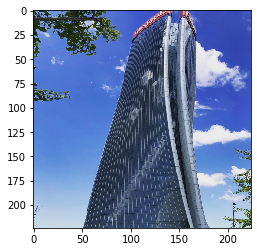

In [0]:
plt.imshow((x_train[0][0][0]+1)/2)



```
# This is formatted as code
```

## architecture

In [0]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (14, 14, 512) # change for output size
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


In [0]:
gan.critic.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 224, 224, 3)       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 112, 112, 64)      4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 56, 56, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 56, 56, 128)       0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 28, 28, 256)       819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 256)       0   

In [0]:
gan.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100352)            10135552  
_________________________________________________________________
batch_normalization_1 (Batch (None, 100352)            401408    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100352)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 512)       0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 28, 28, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 256)       1024

### training

In [0]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 25
N_CRITIC = 5
BATCH_SIZE = 32

In [0]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 (5, 1) [D loss: (-34.1)(R -117.0, F 68.1, G 1.5)] [G loss: -80.0]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 (5, 1) [D loss: (-34.7)(R -128.6, F 76.5, G 1.7)] [G loss: -63.1]
2 (5, 1) [D loss: (-48.0)(R -124.6, F 59.5, G 1.7)] [G loss: -57.7]
3 (5, 1) [D loss: (-38.5)(R -131.6, F 77.2, G 1.6)] [G loss: -84.8]
4 (5, 1) [D loss: (-37.4)(R -126.0, F 70.6, G 1.8)] [G loss: -72.5]
5 (5, 1) [D loss: (-53.0)(R -95.6, F 26.1, G 1.7)] [G loss: -41.1]
6 (5, 1) [D loss: (-30.2)(R -44.4, F -5.5, G 2.0)] [G loss: -20.9]
7 (5, 1) [D loss: (-40.9)(R -94.9, F 36.2, G 1.8)] [G loss: -44.5]
8 (5, 1) [D loss: (-53.0)(R -98.8, F 28.4, G 1.7)] [G loss: -37.5]
9 (5, 1) [D loss: (-42.2)(R -128.2, F 68.7, G 1.7)] [G loss: -75.3]
10 (5, 1) [D loss: (-43.7)(R -144.6, F 84.2, G 1.7)] [G loss: -83.5]
11 (5, 1) [D loss: (-51.4)(R -141.5, F 69.8, G 2.0)] [G loss: -75.8]
12 (5, 1) [D loss: (-34.5)(R -163.8, F 112.1, G 1.7)] [G loss: -95.4]
13 (5, 1) [D loss: (-47.5)(R -119.3, F 52.4, G 1.9)] [G loss: -43.8]
14 (5, 1) [D loss: (-58.8)(R -129.7, F 51.5, G 1.9)] [G loss: -53.8]
15 (5, 1) [D loss: (-43.3)(R -82.5, F 19.2, G 

In [0]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

NameError: ignored